# Submission Information:

### Team Member 1:
* UNI: mf3090
* Name: Michael Figueroa

### Team Member 2 [optional]:
* UNI: baa2146
* Name: Brett Averso

# Step0 - Import Libraries, Load Data [0 points]

This is the basic step where you can load the data and create train and test sets for internal validation as per your convinience.

In [1]:
cd data

/Users/brettaverso/Desktop/homework-iii-baverso/data


In [2]:
#write code below, you can make multiple cells
% matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#from sklearn.gaussian_process import GaussianProcessClassifier
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# CHECK P 295 FOR THIS CURVE TUTORIAL
from sklearn.metrics import roc_curve 

# Step1 - Exploration and Preparation [10 points]

In this step, we expect you to look into the data and try to understand it before modeling. This understanding may lead to some basic data preparation steps which are common across the two model sets required.

In [5]:
#write code below, you can make multiple cells

# NOTE: WE CAN SET NA VALUES HERE TO LOOK AT WHICH ROWS HAVE NA
train = pd.read_csv('data.csv', sep=',', na_values=[999, 9999, 99999, 999999, 9999999])
test = pd.read_csv('holdout.csv', sep=',')
h_ID = test.ID
test = test.drop('ID', axis = 1)
test.columns
# drop duration column (we do not have this information before a new call. we drop to avoid an overly optimistic model)
train = train.drop('duration', axis = 1)
test = test.drop('duration', axis = 1)

In [6]:
# The code is commented out. We originally planned to replace 'unknown' with np.NaN, however decided that
# 'unknown' as a categorical value is a sufficient descriptor for classification.
#train['job'].replace('unknown', np.NaN, inplace=True)
#train['marital_status'].replace('unknown', np.NaN, inplace=True)
#train['education'].replace('unknown', np.NaN, inplace=True)
#train['credit_default'].replace('unknown', np.NaN, inplace=True)
#train['housing'].replace('unknown',np.NaN, inplace=True)
#train['loan'].replace('unknown',np.NaN, inplace=True)

In [7]:
# NOTE: Train and validate your model using data.csv and test on holdout.cv

# NOTE: SVC is sensitive to scaling

# NOTE: random forest n_estimators > 100 main parameter: max_features, set a random state for the random forest

# NOTE: Tuning Gradient Boosting: Pick n_estimators, tune learning rate

# NOTE: DECISION TREES HAVE A .feaure_importance, but for rf and gbt which are unstable means that feature importances are unstable

# NOTE: Linear Models work better if the features are normally distributed

# SET THRESHOLDS THAT ALLOW YOU TO SAY HOW MANY FALSE POSITIVE DO WE ALLOW? HOW MANY FALSE NEGATIVES
# THINK ABOUT THIS WHEN CREATING A SCORING METRIC
# MANY FALSE POSIIVES WILL MEAN THAT OUR CALLER WILL TRY MUCH HARDER AND MAKE MORE PHONE CALLS TO THIS THIS PARTICULAR CLIENT 
# (THIS MAY MEAN THAT TIME IS WASTED THAT COULD BE SPENT ON ANOTHER CUSTOMER)
# MANY FALSE NEGATIVES WILL MEAN THAT WE WILL NOT PAY MUCH ATTENTION TO A CLIENT IN THE FUTURE (THE BANK MAY LOSE MONEY HERE)
# HIGH RECALL = AVOIDING FALSE NEGATIVES
# HIGH PRECISION = AVOIDING FALSE POSITIVES

# NOTE: setting a decision threshold
# on the test set is likely to yield overly optimistic results. Use a
# validation set or cross-validation instead.

# AFTER DECIDING WHICH WE WANT PLOT A PRECISION RECALL CURVE TELLS YOU RECALL VS PRECISION TRADEOFF(POINT HIGHER TO TOP 
# RIGHT MEANS THE CLASSIFIER IS BETTER)

# NOTE: using scoring = 'roc_auc' for selecting hyper parameters such as gamma, is always a good idea for imbalanced datasets
# Keep in mind that AUC does not make use of the default threshold,
# though, so adjusting the decision threshold might be necessary to obtain useful classification
# results from a model with a high AUC.

# Consider using imb.learn to do random over sampling since our dataset is unbalanced
# Or Consider reweight sampling
# Or Consider using SMOTE, all of these need to import imblearn and create a new pipeline

In [8]:
# There are 31707 null values in prev_days (still need to check if there are other missing encodings in other features)
train.prev_days.isnull().value_counts() 
# Therefore dropping this feature
train = train.drop('prev_days', axis = 1)
test = test.drop('prev_days', axis = 1)

In [9]:
# 999 ENCODES MISSING (CHECK FOR OTHERS)
for i in list(test):
    print(test[i].value_counts())

#verifying the existence of any null values other than 'unknown'
dummy_train.isnull().any()

35.0    360
34.0    345
31.0    324
37.0    322
33.0    306
32.0    302
30.0    302
38.0    295
36.0    291
40.0    279
39.0    264
29.0    253
43.0    242
42.0    222
41.0    222
45.0    217
44.0    217
47.0    213
28.0    205
48.0    198
49.0    192
46.0    189
50.0    178
51.0    171
27.0    168
26.0    167
52.0    159
55.0    138
53.0    135
54.0    133
       ... 
63.0     21
17.0     19
19.0     18
66.0     13
65.0     11
18.0     11
69.0     10
70.0      9
67.0      9
68.0      9
71.0      8
75.0      7
72.0      7
74.0      6
78.0      6
79.0      5
76.0      5
73.0      4
80.0      3
84.0      3
93.0      2
77.0      2
85.0      2
81.0      2
82.0      2
96.0      1
88.0      1
86.0      1
90.0      1
83.0      1
Name: age, dtype: int64
admin.           2080
blue-collar      1846
technician       1372
services          801
management        584
retired           330
self-employed     281
entrepreneur      258
housemaid         233
unemployed        217
student           167
un

NameError: name 'dummy_train' is not defined

In [10]:
# we have an imbalanced dataset (~ 10 times more yes classes)
print(" -----%-------")
print(train['subscribed'].value_counts())

 -----%-------
no     29238
yes     3712
Name: subscribed, dtype: int64


In [11]:
#pop subscriptions feature from train set, store in target object.
target = train.subscribed
train = train.drop('subscribed', axis = 1)
train.columns

#assign binary for no and yes
target.replace('no',0, inplace=True)
target.replace('yes',1, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x110809358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1107ec080>]], dtype=object)

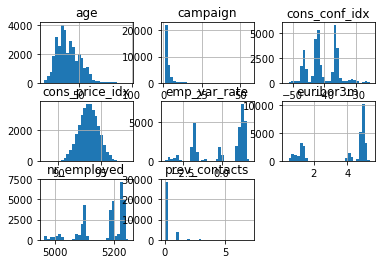

In [12]:
# show histograms of the data for final submission
train.hist(bins=30)

In [13]:
train.describe()

,age,campaign,prev_contacts,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
count,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000,32950.000000
mean,40.019059,2.641639,0.174385,0.080115,93.583705,-40.496740,3.618901,5166.932832
std,10.850807,2.803230,0.498989,1.573180,1.162662,4.645301,1.737149,72.439480
min,17.000000,1.000000,0.000000,-3.695294,88.311974,-52.220779,0.325461,4963.600000
25%,32.000000,1.000000,0.000000,-1.724208,92.800661,-43.087110,1.377065,5101.000000
50%,38.000000,2.000000,0.000000,1.085053,93.586959,-41.685507,4.800570,5194.000000
75%,47.000000,3.000000,0.000000,1.366367,94.381404,-36.404580,4.943674,5226.000000
max,97.000000,56.000000,7.000000,1.785673,98.263042,-25.323735,5.362403,5249.000000


In [14]:
#reviewing the listing of categorical data prior to executing get_dummies
categoricals = list(train.select_dtypes(include=['object']))
categoricals

['job',
 'marital_status',
 'education',
 'credit_default',
 'housing',
 'loan',
 'contact',
 'month',
 'day_of_week',
 'prev_outcomes']

In [15]:
# The below is commented out as we have chosen to preserve the feature label 'unknown' and not encode with NaN or
# impute over it, because per slides, we believe the unknown is an informative value for the model.

#imp = Imputer(missing_values='NaN', strategy='most_frequent')
#imputed_dummy_train = imp.fit_transform(dummy_train)

#imputed_dummy_train = pd.DataFrame(imputed_dummy_train,columns=list(dummy_train))

#OHE = OneHotEncoder(categorical_features=categoricals)
#impute2 = OHE.fit_transform(train)

In [68]:
#creating dummy variables for categorical features
dummy_train = pd.get_dummies(train,dummy_na=False)
dummy_test = pd.get_dummies(test,dummy_na=False)

In [69]:
list(dummy_test)[33]

'credit_default_unknown'

In [70]:
dummy_test.insert(34, 'credit_default_yes', 0)

In [73]:
# scaling the continuous data
continuous_train = dummy_train.select_dtypes(include=['float'])
categorical_train = dummy_train.select_dtypes(exclude=['float'])

continuous_test = dummy_test.select_dtypes(include=['float'])
categorical_test = dummy_test.select_dtypes(exclude=['float'])

scaler = StandardScaler()
dummy_train_scaled = scaler.fit_transform(continuous_train)
dummy_test_scaled = scaler.fit_transform(continuous_test)
dummy_train_scaled = pd.DataFrame(dummy_train_scaled,columns=list(continuous_train))
dummy_test_scaled = pd.DataFrame(dummy_test_scaled,columns=list(continuous_test))

# Combining continuous and dummy features back into a single train data frame.
X_train = pd.concat([dummy_train_scaled, categorical_train],axis=1)
X_test = pd.concat([dummy_test_scaled,categorical_test],axis=1)

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
32920    0
32921    0
32922    0
32923    0
32924    0
32925    0
32926    0
32927    0
32928    0
32929    0
32930    0
32931    0
32932    0
32933    0
32934    0
32935    0
32936    0
32937    0
32938    0
32939    0
32940    0
32941    0
32942    0
32943    0
32944    0
32945    0
32946    0
32947    0
32948    0
32949    0
Name: subscribed, dtype: int64

# Step2 - ModelSet1 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set1:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. Any classification algorithm covered in class apart from tree-based models can be tested here.

In [91]:
def model_1(X_train, y_train, X_test):
    logit = LogisticRegression()
    pipe = make_pipeline(logit)
    scores = cross_val_score(pipe, X_train, y_train, cv=5)
    print(np.mean(scores))
    pipe.fit(X_train, y_train)
    pipe.score(X_train, y_train)
    y_prob = pd.concat([h_ID, pd.DataFrame(pipe.predict_proba(X_test)).ix[:,[1]]], axis = 1)
    y_prob.columns = ['ID', 'subscribed']
    y_prob.to_csv('logistic.csv', index=False)
    return y_prob

model_1(X_train, y_train, X_test)

0.899241433984


,ID,subscribed
0,2866,0.031388
1,1957,0.021497
2,768,0.073652
3,4510,0.019780
4,7893,0.041529
5,5540,0.061461
6,385,0.181131
7,5152,0.048427
8,1770,0.048535
9,5779,0.036525


In [ ]:
test

# Step3 - ModelSet2 [35 points]

In this step, we expect you to perform the following steps relevant to the models you choose for set2:

* feature engineering
* validation
* feature selection
* final model selection

You may select up to 5 models in this step for the purpose of final ensemble. We encourage you to try decition tree, random forest and gradient boosted tree methods here and pick the one which you think works best.

In [ ]:
#write code below, you can make multiple cells

# Step4 - Ensemble [20 points + 10 Bonus points]

In this step, we expect you to use the models created before and create new predictions. You should definitely try poor man's stacking but we encourage you to think of different ensemble techniques as well. We will judge your creativity and improvement in model performance using ensemble models and you can potentially earn 10 bonus points here.

In [ ]:
#write code below, you can make multiple cells
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
X = X_train
y = y_train
eclf1 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
eclf1 = eclf1.fit(X, y)
predictions1 = (eclf1.predict(X))
eclf2 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')
eclf2 = eclf2.fit(X, y)
predictions2 = (eclf2.predict(X))
eclf3 = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[2,1,1])
eclf3 = eclf3.fit(X, y)
predictions3 = (eclf3.predict(X))

In [ ]:
eclf1.score(X,y)